In [60]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [61]:
'''
Have a system consisting of the Sun, Earth, Mars and a probe near Earth. The probe has initial conditions as specified.
Define a 'cost funciton' chi: root((r-x)^2) where r is the distance from the probe to Mars, and x the probe's x position.
Study the impact of slightly varying the probe's vx on the cost.

Have Chi(vx) = Chi(vx_0) + (vx-vx_0)dChi/dvx + 1/2 * (vx-vx_0)^2 * d^2Chi/dvx^2
'''

def calculate_xpos(vx):
    sim = rebound.Simulation()
    sim.units = ('days', 'AU', 'Msun')
    sim.add(m=1)   # add the Sun
    sim.add(m=2.95e-6, x=-9.553332553595898E-01, y=2.597998306814548E-01, z=-1.543956066889573E-04,\
             vx=-4.706756316258911E-03, vy=-1.668349263230294E-02, vz=5.695492035762669E-07) 
    sim.add(m=3.21e-7, x=8.918463729934603E-01, y=1.186669132977336E+00, z=2.814474243868692E-03\
            ,vx=-1.065797950598695E-02, vy=9.608537631633303E-03, vz=4.627734429853369E-04)
    # Now add a small probe near to Earth.
    sim.add(m=1e-28, x=-9.0E-01, y= 2.0E-01, z=0, vx=vx, \
        vy=-1.2E-02, vz=0)
    ps = sim.particles
    sim.integrate(365) # integrate for 1 Earth year
    return [ps[3].x, ps[3].y, ps[3].z, ps[2].x, ps[2].y, ps[2].z] # get positions back

#print "Probe with vx=-1.0E-02 gives probe position: {}\n\t\t\t Mars position: {}".format(calculate_xpos(vx=-1.0E-02)[0:3],\
#                                                                                  calculate_xpos(vx=-1.0E-02)[3:])

#print "Probe with vx=-1.5E-02 gives probe position: {}\n\t\t\t Mars position: {}".format(calculate_xpos(vx=-1.5E-02)[0:3],\
#                                                                                 calculate_xpos(vx=-1.5E-02)[3:])



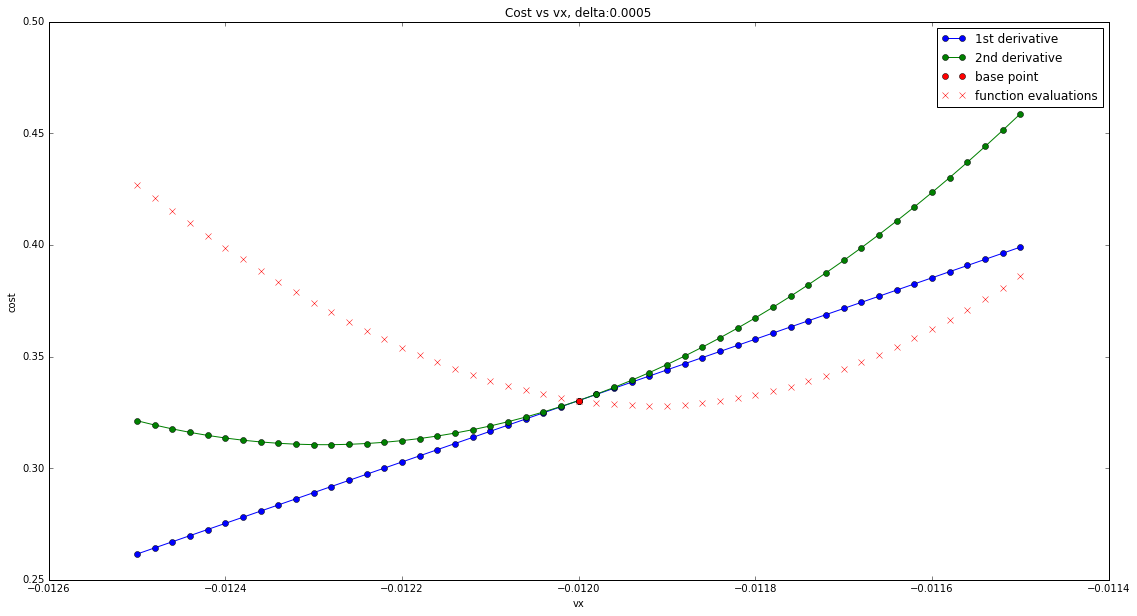

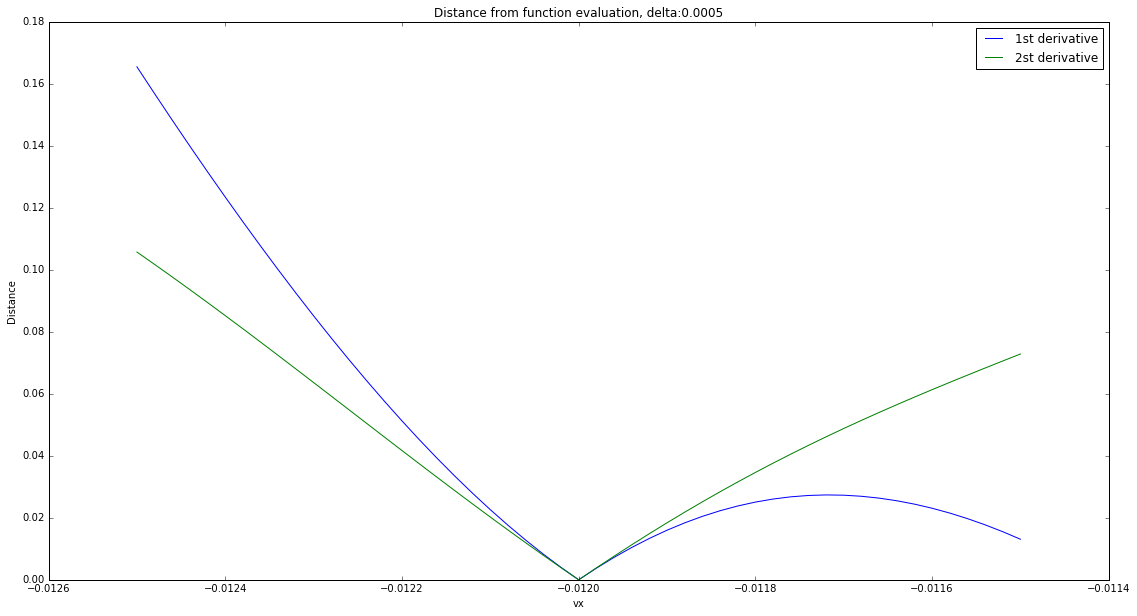

In [81]:
'''
Have a system consisting of the Sun, Earth, Mars and a probe near Earth. The probe has initial conditions as specified.
Define a 'cost funciton' chi: root((r-x)^2) where r is the position of Mars, and x the probe's x position.
Study the impact of slightly varying the probe's vx on the cost.

Have Chi(vx) = Chi(vx_0) + (vx-vx_0)dChi/dvx + 1/2 * (vx-vx_0)^2 * d^2Chi/dvx^2

dChi/dvx = dChi/dx * dx/dvx
dChi/dx = (x-r)/root((r-x)^2)

get dx/dvx from variation
'''

'''
Cost function and its derivatives
'''

def cost(r, x):
    '''r, x are 3-component arrays, r being the position of Mars, and x being the position of the probe'''
    cost = np.sum(np.square(r-x))
    return np.sqrt(cost)

def dcost_dx(r, x):
    return (x[0]-r[0])/cost(r,x)

def dcost2_dx2(r, x):
    return 1./cost(r,x) - (x[0]-r[0])**2/cost(r,x)**3

def calculate_xpos_deriv(vx_0):
    sim = rebound.Simulation()
    sim.units = ('days', 'AU', 'Msun')
    sim.add(m=1)   # add the Sun
    sim.add(m=2.95e-6, x=-9.553332553595898E-01, y=2.597998306814548E-01, z=-1.543956066889573E-04,\
             vx=-4.706756316258911E-03, vy=-1.668349263230294E-02, vz=5.695492035762669E-07) 
    sim.add(m=3.21e-7, x=8.918463729934603E-01, y=1.186669132977336E+00, z=2.814474243868692E-03\
            ,vx=-1.065797950598695E-02, vy=9.608537631633303E-03, vz=4.627734429853369E-04)
    # Now add a small probe near to Earth.
    sim.add(m=1e-28, x=-9.0E-01, y= 2.0E-01, z=0, vx=vx_0, \
        vy=-1.2E-02, vz=0)
    v1 = sim.add_variation() # add a set of variational particles
    v1.particles[3].vx = 1 
    v2 = sim.add_variation(order=2, first_order=v1)
    v2.particles[3].vx = 1
    
    sim.integrate(365) # integrate for 1 Earth year
    return [sim.particles[3].x, sim.particles[3].y, sim.particles[3].z, sim.particles[2].x, sim.particles[2].y, \
            sim.particles[2].z], v1.particles[3].x, v2.particles[3].x # get positions back, and x derivatives

vx_0 = -1.2E-02
pos, dxpos, d2xpos = calculate_xpos_deriv(vx_0) # get position vectors for probe, Mars, and vx for probe.
r = np.array(pos[3:]) # position of MARS
pos = np.array(pos[:3]) # position of PROBE
cost_base = cost(r,pos)

'''
Now that we have the base cost of the trip, lets vary vx_0 slightly
'''
delta = 5E-4
sim_calc = []
vary_costs = []
vary_costs_2 = []
vx_vari = np.arange(vx_0-delta, vx_0+delta, delta/25.)
for vel in vx_vari:
    vary_costs.append(cost_base + (vel-vx_0)*dcost_dx(r, pos)*dxpos) # base + (vx_0-vel) * dcost/dx *dx/dv
    # base + (vx_0-vel) * dcost/dx * dx/dv + 0.5*(vx_0-vel)**2 * d/dx(dcost/dx) * d/dv(dx/dv)
    vary_costs_2.append(cost_base + (vel-vx_0)*dcost_dx(r, pos)*dxpos + 0.5*(vel-vx_0)**2*dcost2_dx2(r, pos)*d2xpos)
    calc = np.array(calculate_xpos(vel))
    sim_calc.append(cost(calc[3:], calc[:3]))
    
vary_costs = np.array(vary_costs)    
vary_costs_2 = np.array(vary_costs_2)
sim_calc = np.array(sim_calc)

plt.figure(1, figsize=(19,10))
plt.plot(vx_vari, vary_costs, '-ob', label='1st derivative')
plt.plot(vx_vari, vary_costs_2, '-og', label='2nd derivative')
plt.plot(vx_0, cost_base, 'or', label='base point')
plt.plot(vx_vari, sim_calc, 'rx', label = 'function evaluations')
plt.xlabel('vx')
plt.title('Cost vs vx, delta:{}'.format(delta))
plt.ylabel('cost')
plt.legend()
plt.savefig('Cost for vx_0:-0.012 delta:{}.png'.format(delta))
plt.show()

plt.figure(2, figsize=(19, 10))
plt.plot(vx_vari, np.abs(vary_costs-sim_calc), '-b', label="1st derivative")
plt.plot(vx_vari, np.abs(vary_costs_2-sim_calc), '-g', label="2st derivative")
plt.xlabel('vx')
plt.title('Distance from function evaluation, delta:{}'.format(delta))
plt.ylabel('Distance')
plt.legend()
plt.savefig('Distance from function evaluation, delta:{}.png'.format(delta))
plt.show()

In [72]:
vx_vari


array([-0.013  , -0.01296, -0.01292, -0.01288, -0.01284, -0.0128 ,
       -0.01276, -0.01272, -0.01268, -0.01264, -0.0126 , -0.01256,
       -0.01252, -0.01248, -0.01244, -0.0124 , -0.01236, -0.01232,
       -0.01228, -0.01224, -0.0122 , -0.01216, -0.01212, -0.01208,
       -0.01204, -0.012  , -0.01196, -0.01192, -0.01188, -0.01184,
       -0.0118 , -0.01176, -0.01172, -0.01168, -0.01164, -0.0116 ,
       -0.01156, -0.01152, -0.01148, -0.01144, -0.0114 , -0.01136,
       -0.01132, -0.01128, -0.01124, -0.0112 , -0.01116, -0.01112,
       -0.01108, -0.01104, -0.011  ])

In [73]:
vx_0+delta, vx_0-delta

(-0.011, -0.013000000000000001)

In [71]:
vx_0

-0.012